In [1]:
import os, glob
import numpy as np
import xarray as xr
from enum import Enum
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from glob import glob
import sys
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
sys.path.append('modules')
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import constants
sys.path.append(constants.MODULE_DIR)
import open_ds
import xarray_class_accessors as xca
from importlib import reload
import sn_plotting
import utils
import xarray_extender as xce
import warnings 
import signal_to_noise as sn
warnings.filterwarnings('ignore')

In [2]:
from typing import List, Tuple

In [4]:
constants.ZECMIP_LOCAL_REGRIDDED_DIR

'/g/data/w40/ab2313/PhD/zecmip/regridded'

In [5]:
class LocationsLatLon(Enum):
    '''Latittude and longitude of different locations around the world'''
    EPACIFIC = (2.7 ,-85)
    NATLANTIC = (2.2, -8)
    ECHINA_SEA = (26, 128)
    MELBOURNE = (-38, 145)
    LONDON = (51, 0.12)
    NEW_YORK = (40.7, 74)
    BEIJING = (40, 116) 
    BUENOS_AIRES = (35, 58)
    KINSHASA = (4.4, 15.2)
    ARCTIC = (76, 100)
    JAKARTA = (-6.2088, 106.84)

# Opening and Processing

In [7]:
window = 25

In [8]:
open_kwargs = dict(use_cftime=True, 
                  chunks = {'lat': 100, 'lon': 100, 'time': -1})

In [9]:
experiment_ds = xr.open_mfdataset(os.path.join(constants.ZECMIP_LOCAL_REGRIDDED_DIR, '4xCO2', '*.nc'), 
                                 **open_kwargs).compute()
experiment_ds = experiment_ds.isel(time=slice(0,100))

In [10]:
picontrol_ds = xr.open_mfdataset(os.path.join(constants.ZECMIP_LOCAL_REGRIDDED_DIR, 'picontrol', '*.nc'), 
                  use_cftime=True, concat_dim='model', combine='nested').compute()

In [14]:
loess_picontrol_ds = xr.open_dataset(os.path.join(constants.ZECMIP_LOCAL_REGRIDDED_DIR, 'loess', f'control_{window}.nc'),
                                     use_cftime=True)

In [19]:
loess_experiment_ds = xr.open_dataset(os.path.join(constants.ZECMIP_LOCAL_REGRIDDED_DIR, 'loess', f'1pct_CO2_branch_{window}.nc'),
                                     use_cftime=True)

In [21]:
%%time
ds_sn, ds_sn_stable, ds_sn_increasing, ds_sn_decreasing = sn.global_sn(experiment_ds.tas, picontrol_ds.tas, 
             loess_experiment_ds.tas, loess_picontrol_ds.tas, 
             window=window)

CPU times: user 6h 25min 14s, sys: 2min 37s, total: 6h 27min 52s
Wall time: 6h 32min 35s


In [23]:
period_list = utils.create_period_list(step = window, end = 3, start = 0)
period_list

[(0, 24), (25, 49), (50, 74)]

In [24]:
percent_stable_ds = sn.percent_of_non_nan_points_in_period(ds_sn_stable, period_list)
percent_stable_ds

(0, 24) - 25 years
(25, 49) - 25 years
(50, 74) - 25 years


<xarray.Dataset>
Dimensions:      (lat: 96, lon: 192, period: 3, model: 8)
Coordinates:
    height       float64 2.0
  * lat          (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 84.86 86.72 88.57
  * lon          (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * period       (period) object '0_24' '25_49' '50_74'
  * model        (model) object 'CESM2' 'CanESM5' ... 'NorESM2-LM' 'UKESM1-0-LL'
Data variables:
    mean         (period, lat, lon) float64 94.0 94.0 94.0 ... 90.5 90.5 91.0
    uncertainty  (period, lat, lon) float64 12.0 12.0 12.0 ... 20.0 20.0 20.0
    percent      (period, model, lat, lon) float64 92.0 92.0 92.0 ... 96.0 96.0

## Plotting

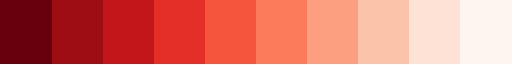

In [25]:
cmap = plt.cm.get_cmap('Reds_r', 10)
cmap

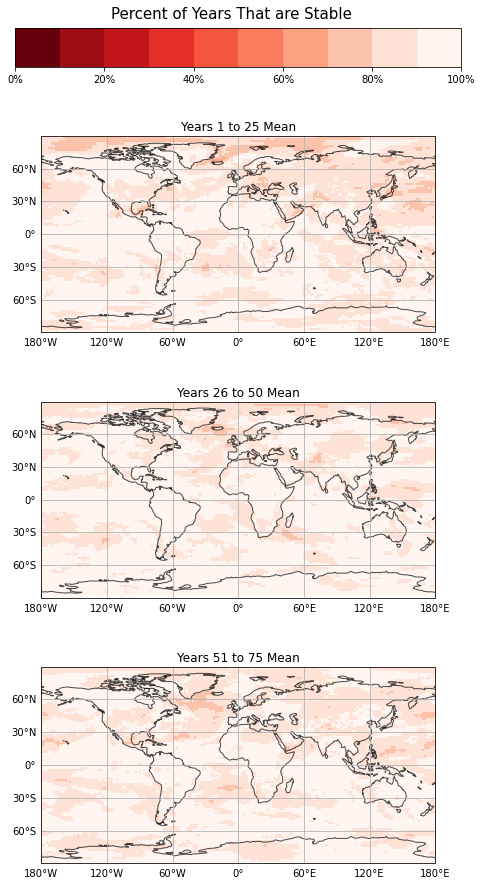

In [58]:
reload(sn_plotting)
periods = percent_stable_ds.period.values[:6]

fig, gs, cbar = sn_plotting.plot_all_period_maps(percent_stable_ds[['mean']], periods,
                                       suptitle = 'Percent of Years That are Stable', cmap=cmap, 
                                      col_increase = 1, row_increase=1, y=0.93)
fig.savefig(os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL, 'zec_05_percent_20_window_years_20_year_periods.png'),
           bbox_inches='tight', dpi=250)


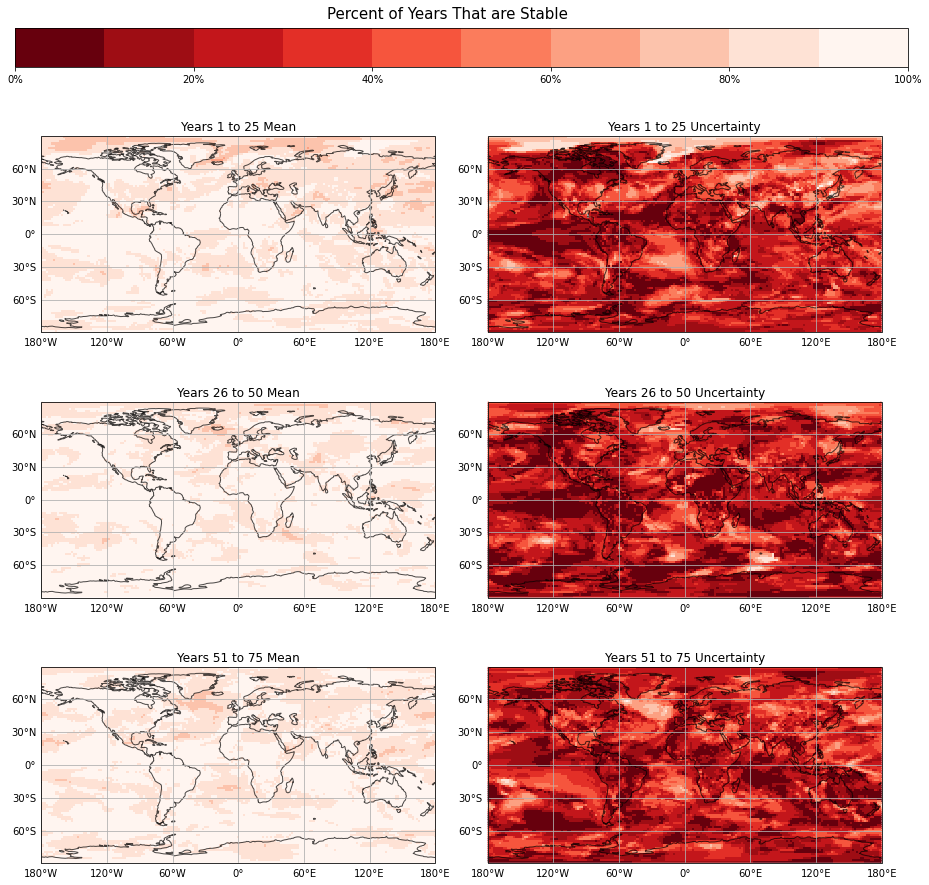

In [60]:
reload(sn)
periods = percent_stable_ds.period.values[:6]
fig, gs, cbar =  sn_plotting.plot_all_period_maps(percent_stable_ds[['mean', 'uncertainty']], periods,
                                       suptitle = 'Percent of Years That are Stable', cmap=cmap)

fig.savefig(os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL, 
                         'zec_05_percent_years_stable_25_year_window.png'),
           bbox_inches='tight', dpi=250)

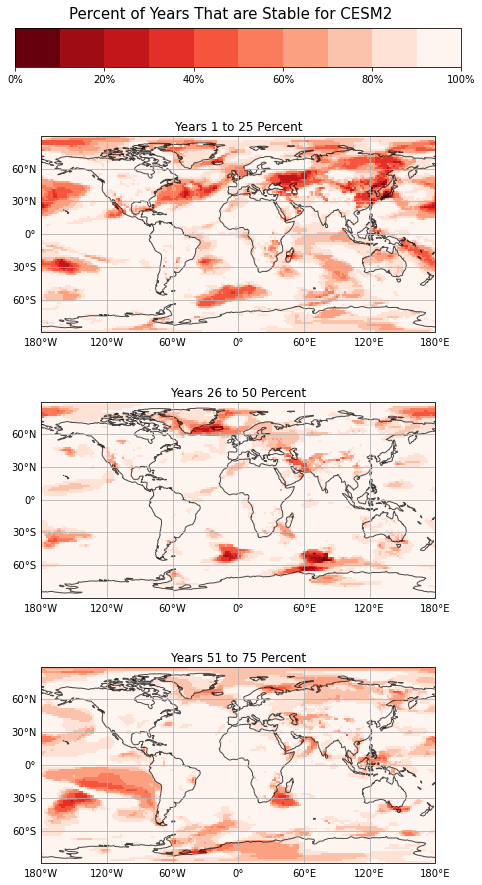

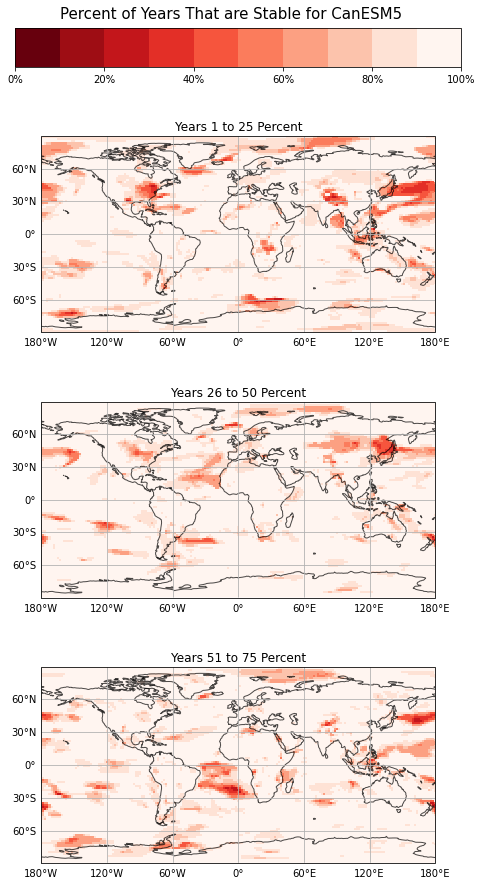

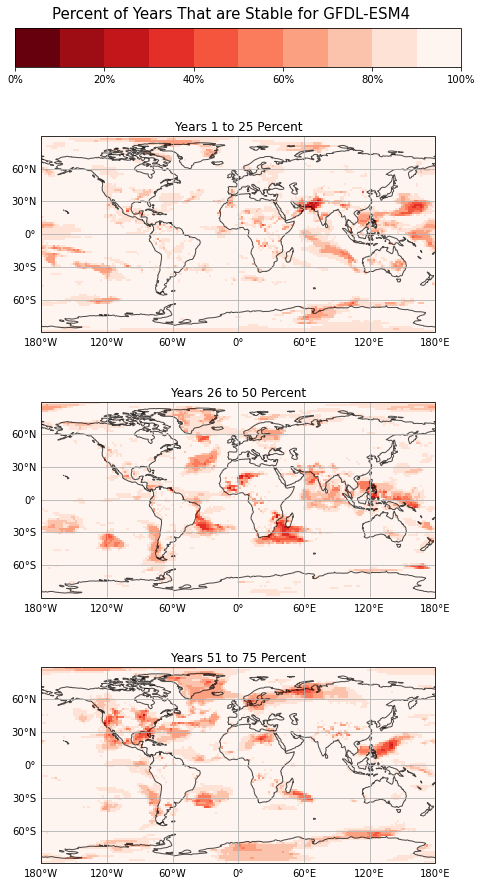

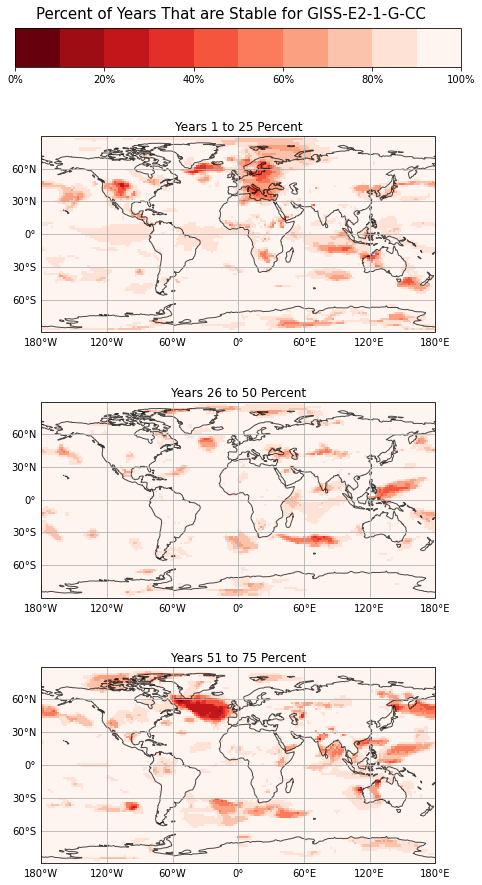

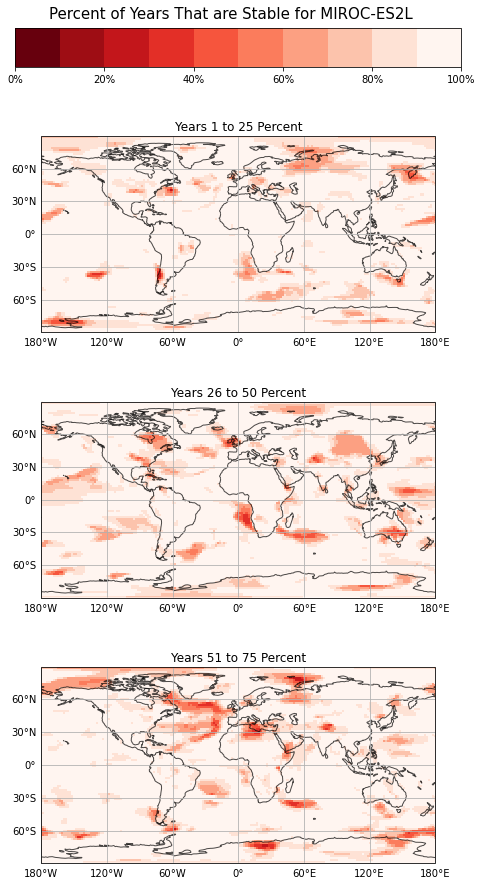

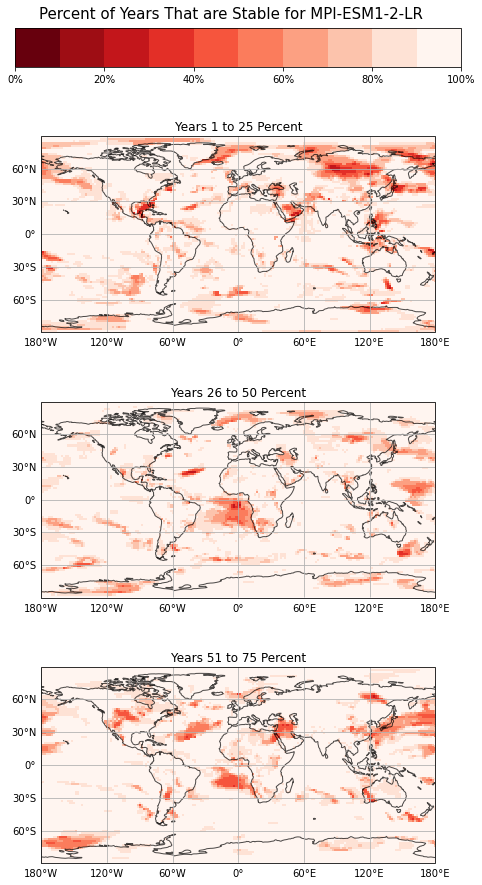

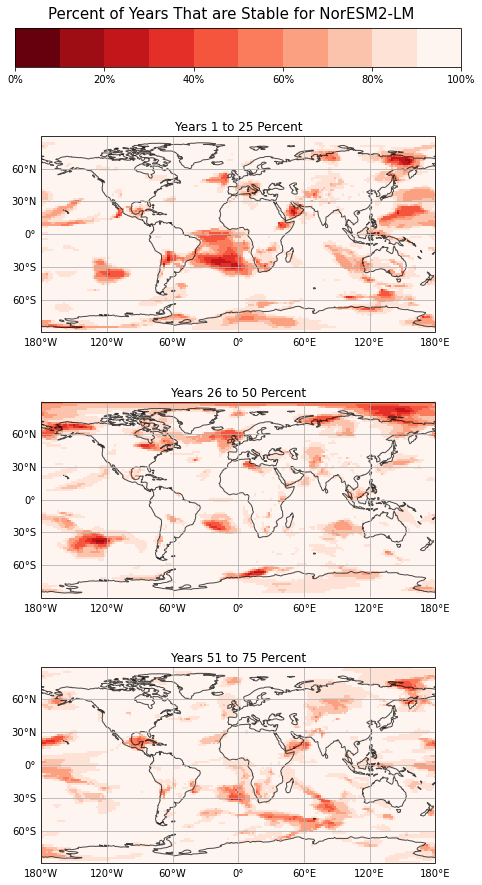

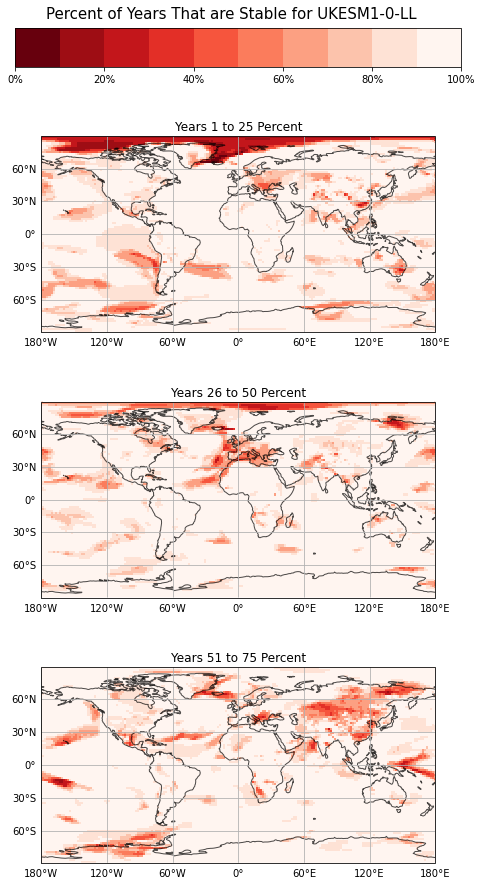

In [62]:
periods = percent_stable_ds.period.values
models = percent_stable_ds.model.values
reload(sn_plotting)
for model in models:
    fig, gs, cbar = sn_plotting.plot_all_period_maps(percent_stable_ds[['percent']].sel(model=model), periods,
                                           suptitle = f'Percent of Years That are Stable for {model}',
                                           cmap=cmap, row_increase = 2, y=0.89)
    fig.savefig(os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL, 
                             f'zec_05_percent_years_stable_25_year_window_{model}.png'),
               bbox_inches='tight', dpi=250)

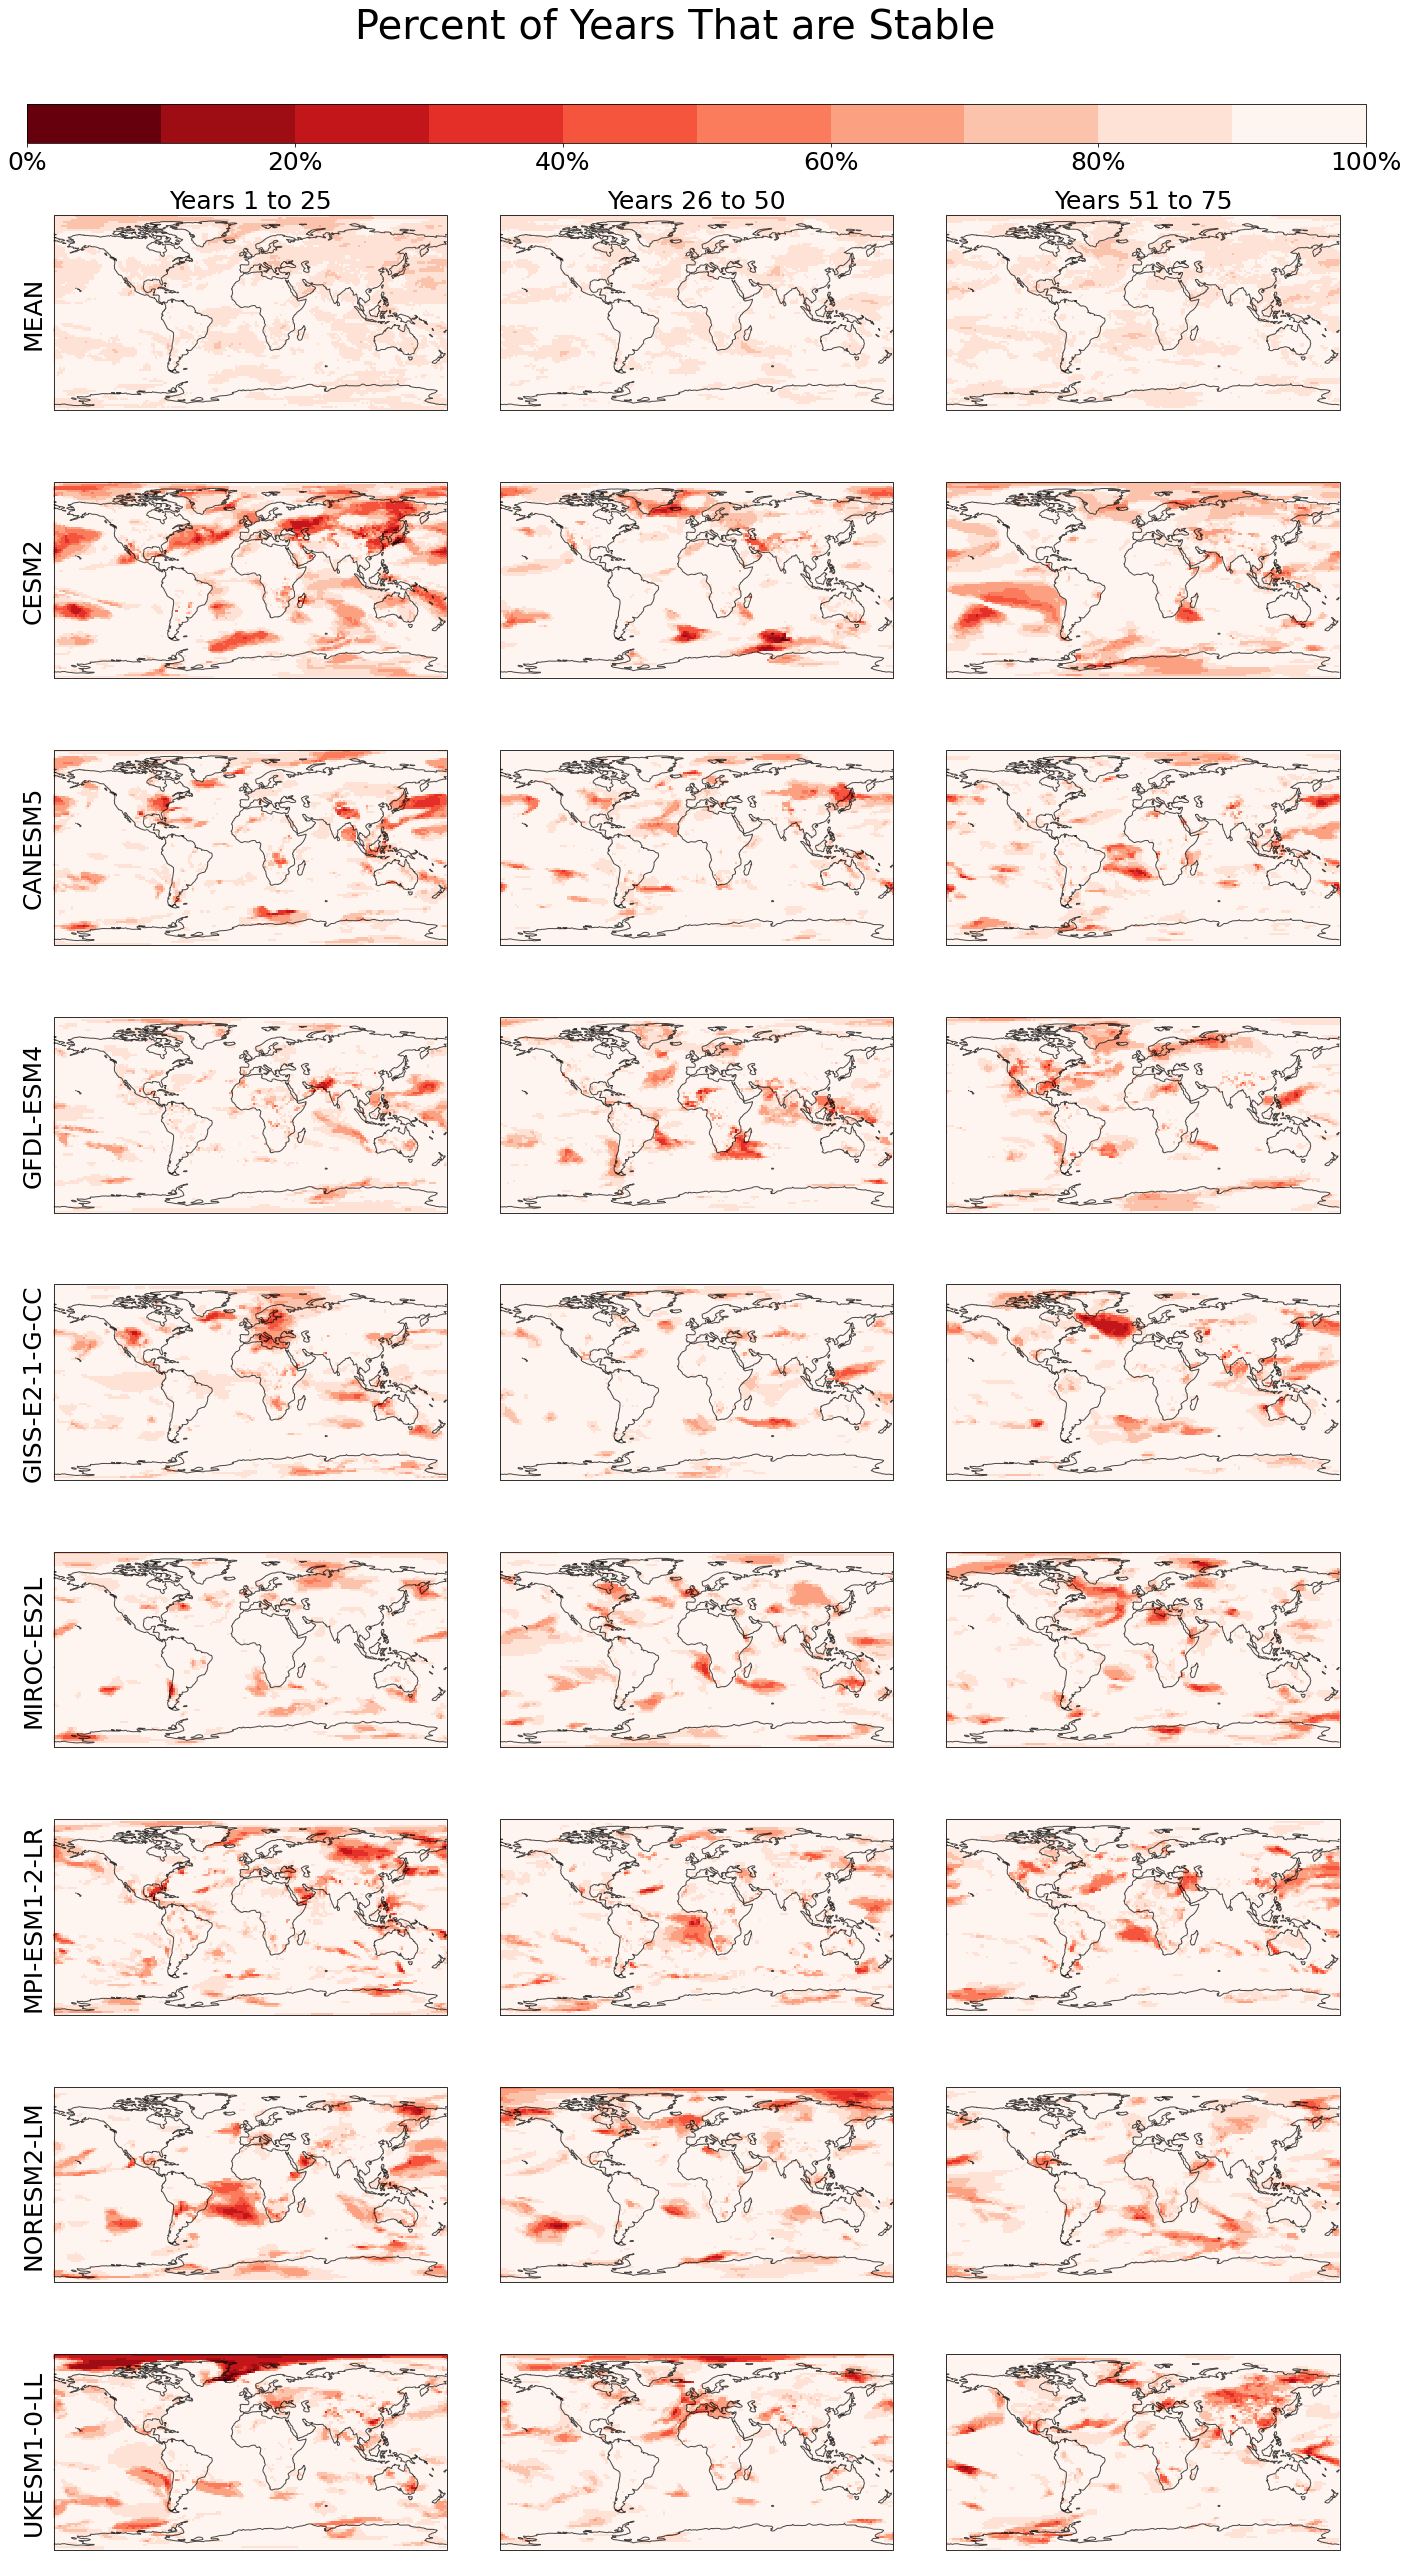

In [65]:
periods = percent_stable_ds.period.values[:4]
models = percent_stable_ds.model.values
models = np.insert(models, 0, 'mean')

ncols = len(periods)
nrows = len(models)
fig = plt.figure(figsize = (8 * ncols, 5 * nrows))
fig.suptitle('Percent of Years That are Stable', y=0.91, fontsize=40)

gs = gridspec.GridSpec(nrows + 1, ncols, height_ratios = [.2] + [1] * nrows, hspace=0.4, wspace=0)

for row_num, model in enumerate(models, 1):
    for col_num, period in enumerate(periods):
        ax = fig.add_subplot(gs[row_num, col_num], projection=ccrs.PlateCarree())
        
        if model == 'mean':
            da = percent_stable_ds['mean']
        else:
            da = percent_stable_ds['percent'].sel(model=model)

        pcolor = da.sel(period=period).plot(
            ax=ax, vmin=0, vmax=100, cmap=cmap, extend='neither', add_colorbar=False)
        ax.coastlines(alpha=0.7)

        if row_num == 1:
            ax.set_title(utils.convert_period_string(period), fontsize=25);
        else:
            ax.set_title('')
        
        if col_num == 0:
            ax.annotate(model.upper(), size=25, xy = (-.05, 0.5), clip_on=True, xycoords= 'axes fraction',
                       rotation=90, ha='center', va='center')
        
#         plot_num += 1
    
cbar = sn_plotting.format_colorbar(gs, pcolor, labelsize=25)  

fig.savefig(os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL,
                         'zec_05_percent_years_stable_25_year_window_all_models.png'),
           bbox_inches='tight')

# Pattern Correlation - Incomplete For ZEC

In [ ]:
assert 1=0

In [132]:

models = percent_ds.model.values
periods = percent_ds.period.values

pattern_corr_dict = {}
for period in periods:
#     flat_mean = percent_mean_ds.sel(period=period).values.flatten()
    period_dict = {}
    for model in models:
        
        percent_drop_model_ds = percent_ds.where(percent_ds.model.isin(models[models != model]), drop=True)
        percent_drop_model_ds = percent_drop_model_ds['percent'].sel(period = period)
        percent_drop_model_mean_np = percent_drop_model_ds.mean(dim='model').values.flatten()
        
        percent_da = percent_ds['percent'].sel(model=model, period=period)
        percent_np = percent_da.values.flatten()

        pattern_corr = spearmanr(percent_np, percent_drop_model_mean_np)

        period_dict[model] = pattern_corr[0]
    pattern_corr_dict[period] = period_dict

In [133]:
pattern_corr_df = pd.DataFrame(pattern_corr_dict)
pattern_corr_df

0_24     25_49     50_99   100_149   150_199   200_249  \
IPSLCM5A  0.357160  0.583652  0.407047  0.155629  0.107268  0.221087   
CNRMCM61  0.624505  0.628574  0.406271  0.063841  0.143045  0.195973   
HadCM3L   0.480382  0.078263 -0.073833  0.156754  0.197782  0.153336   
MPIESM12  0.402736  0.520399  0.312985  0.253550  0.111051  0.184507   
GISSE2R   0.482096  0.435225  0.260776  0.063040  0.059983  0.075878   
CCSM3     0.332711  0.183992  0.407280  0.169622  0.030572  0.262683   
FAMOUS    0.110466  0.149901  0.253918  0.071493  0.016339  0.027377   
MPIESM11  0.524311  0.492653  0.210859  0.009693 -0.076129  0.020757   
CESM104   0.534120  0.517067  0.224631  0.242013  0.172853  0.103043   

           250_299   300_349   350_399   400_449  
IPSLCM5A -0.001753  0.028064  0.143750  0.034933  
CNRMCM61  0.189047  0.002872  0.196054  0.138280  
HadCM3L   0.162843  0.118573  0.195899  0.133144  
MPIESM12  0.101143  0.009597  0.179888  0.089024  
GISSE2R   0.033965 -0.075036  0.028220  0.066129  
CCSM3     0.041797  0.048262  0.131593  0.070813  
FAMOUS    0.183069  0.104115  0.116910 -0.021399  
MPIESM11  0.052264 -0.230590 -0.042382 -0.038819  
CESM104   0.240169 -0.067032  0.178749 -0.017466

In [134]:
xticklabels = [convert_period_string(period) for period in percent_mean_ds.period.values]
xticklabels = [' '.join(x.split(' ')[1:]) for x in xticklabels] # Getting rid of "Years" string start
xticklabels

['1 to 25',
 '26 to 50',
 '51 to 100',
 '101 to 150',
 '151 to 200',
 '201 to 250',
 '251 to 300',
 '301 to 350',
 '351 to 400',
 '401 to 450']

Text(95.72222222222221, 0.5, 'Model')

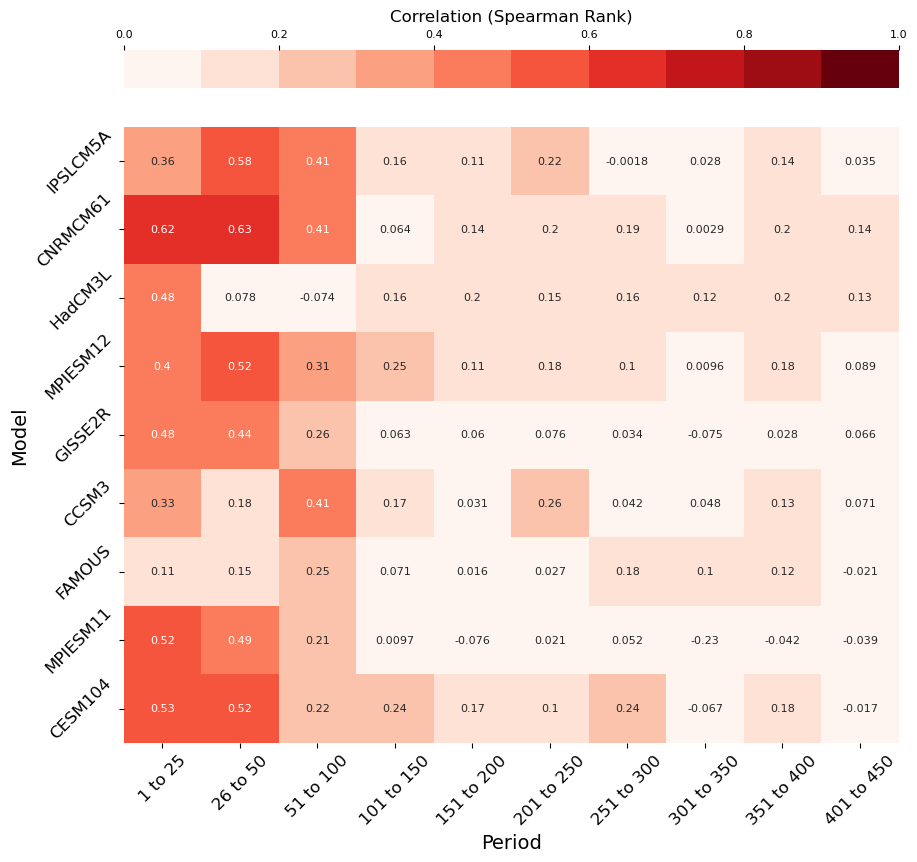

In [135]:
fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(pattern_corr_df, cmap=cmap.reversed(), vmin=0, vmax=1, annot=True, 
           cbar_kws=dict(location='top'), xticklabels = xticklabels,
                annot_kws = dict(fontsize=8))


ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=12, rotation=45)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=12, rotation=45)


cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=8)
cbar.ax.set_title('Correlation (Spearman Rank)', fontsize=12)

plt.xlabel("Period", size=14)
plt.ylabel("Model", size=14)

# fig.savefig(os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL, '07_percent_stable_heat_map.png'), 
#            bbox_inches='tight', dpi=200)

# Consecutive Metrics

In [32]:
def single_plot(fig, ax, data, title=''):
    
    data.plot(ax=ax, cmap='Reds', robust=True)

    ax.set_title(title)
    ax.coastlines(alpha=0.7)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False


In [52]:
consec_ds

<xarray.Dataset>
Dimensions:              (lon: 144, lat: 72, model: 9)
Coordinates:
    time                 object 0000-12-31 00:00:00
  * lon                  (lon) float64 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * lat                  (lat) float64 -88.75 -86.25 -83.75 ... 86.25 88.75
  * model                (model) object 'MPIESM12' 'IPSLCM5A' ... 'CCSM3'
Data variables:
    first_stable         (model, lat, lon) float64 21.0 21.0 21.0 ... 15.0 15.0
    average_length       (model, lat, lon) float64 25.94 24.53 ... 117.2 117.2
    number_periods       (model, lat, lon) float64 16.0 17.0 15.0 ... 4.0 4.0
    total_time_stable    (model, lat, lon) float64 415.0 417.0 ... 469.0 469.0
    percent_time_stable  (model, lat, lon) float64 82.83 83.23 ... 93.61 93.61

In [53]:
consec_ds_range = consec_ds.max(dim='model') - consec_ds.min(dim='model')

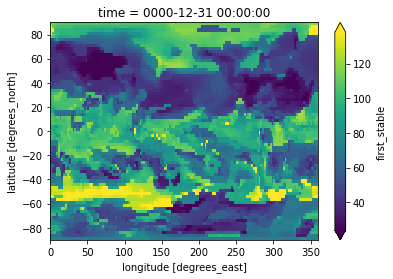

In [54]:
consec_ds_range['first_stable'].plot(robust=True)

In [58]:
def single_plot(fig, ax, data, title=''):
    
    data.plot(ax=ax, cmap='Reds', robust=True)

    ax.set_title(title)
    ax.coastlines(alpha=0.7)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False


In [74]:
import cartopy.crs as ccrs

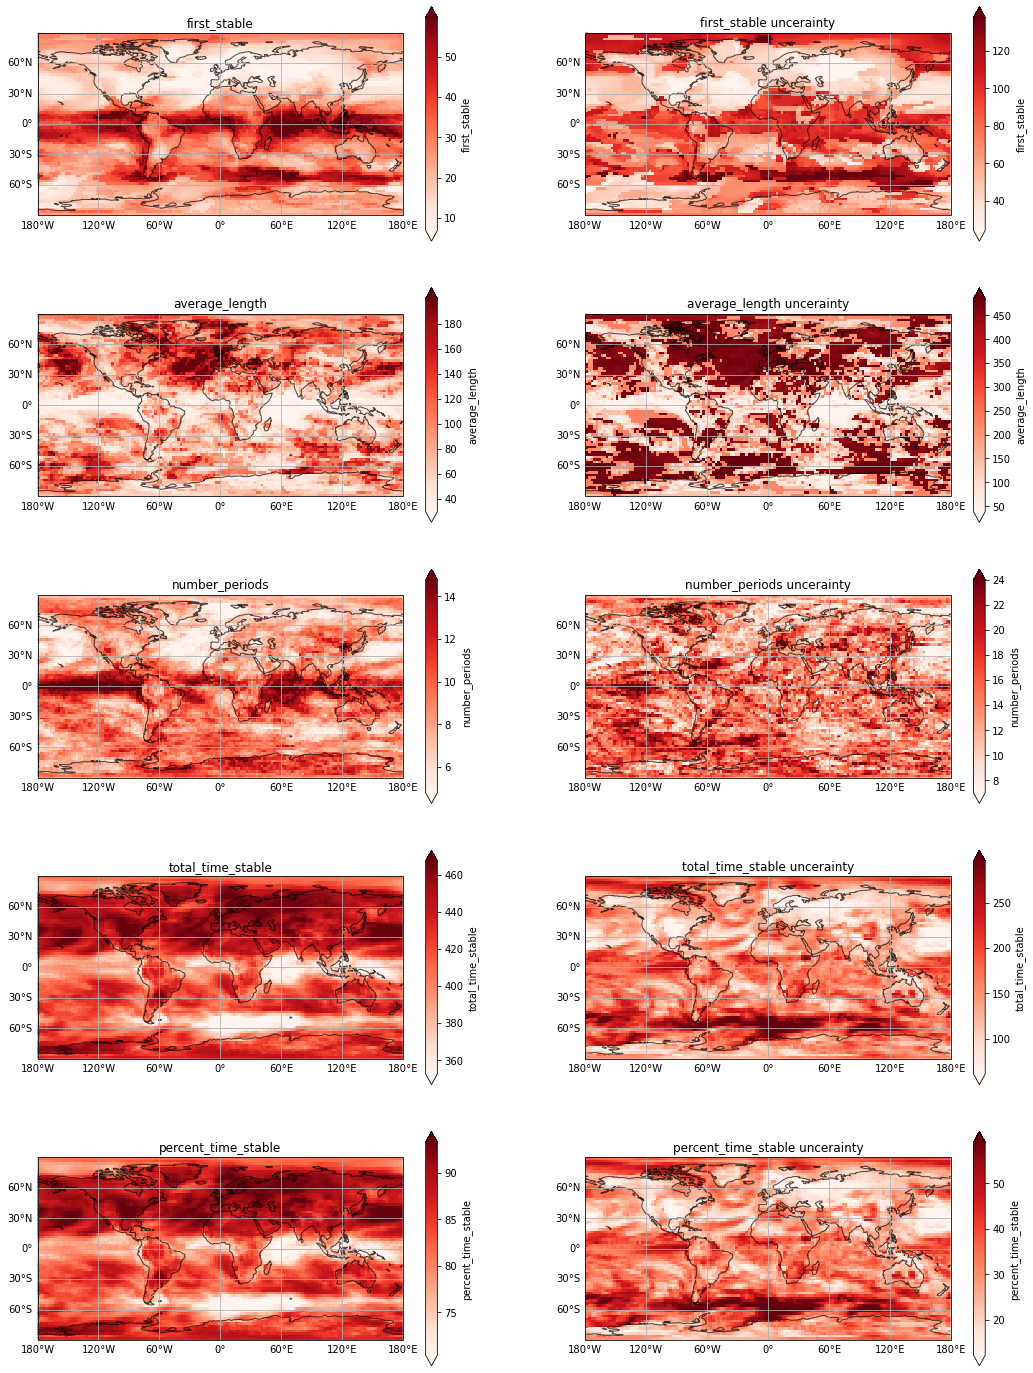

In [59]:
data_vars = list(consec_ds.data_vars)
fig = plt.figure(figsize = (18, 5 * len(data_vars)))

i = 0
for dvar in data_vars:
    ax = fig.add_subplot(len(data_vars), 2, i+1, projection=ccrs.PlateCarree())
    single_plot(fig, ax, consec_ds[dvar].mean(dim='model'), dvar)
    i += 1
    
    ax = fig.add_subplot(len(data_vars), 2, i+1, projection=ccrs.PlateCarree())
    single_plot(fig, ax, consec_ds_range[dvar], dvar + ' uncerainty')
    i += 1


In [69]:

def plot_all_model_maps(ds, variable):
    da = ds[variable]
    models = list(da.model.values)
    fig = plt.figure(figsize = (18, 5 * len(data_vars)))

    for i,model in enumerate(models):
        ax = fig.add_subplot(int(np.ceil(len(models)/2)), 2, i+1, projection=ccrs.PlateCarree())
        single_plot(fig, ax, da.sel(model=model), model)


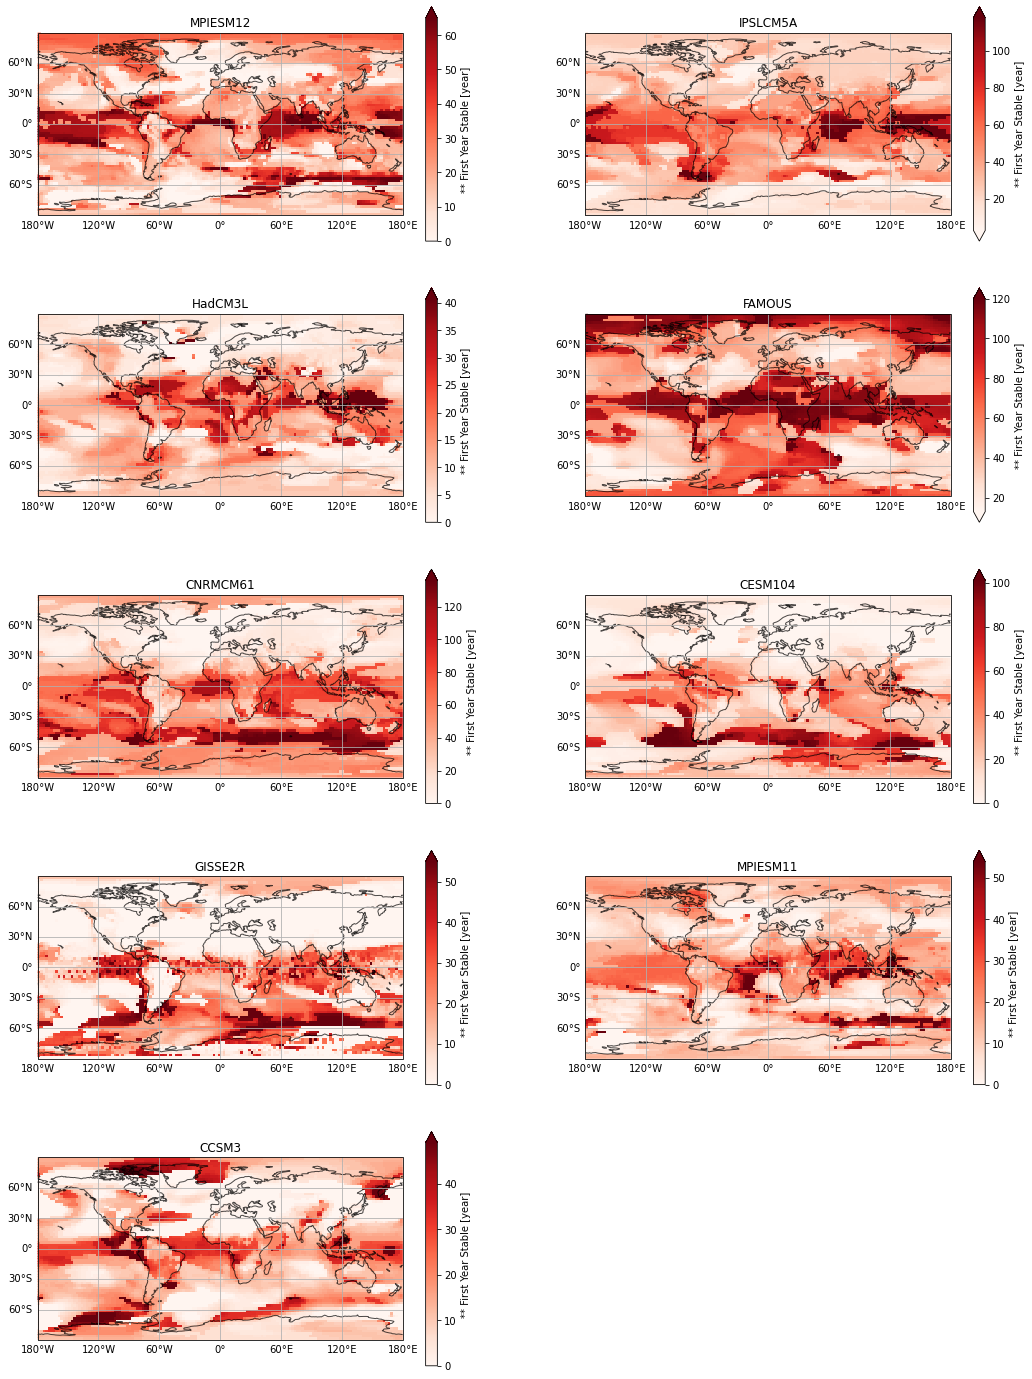

In [71]:
plot_all_model_maps(consec_ds, 'first_stable')

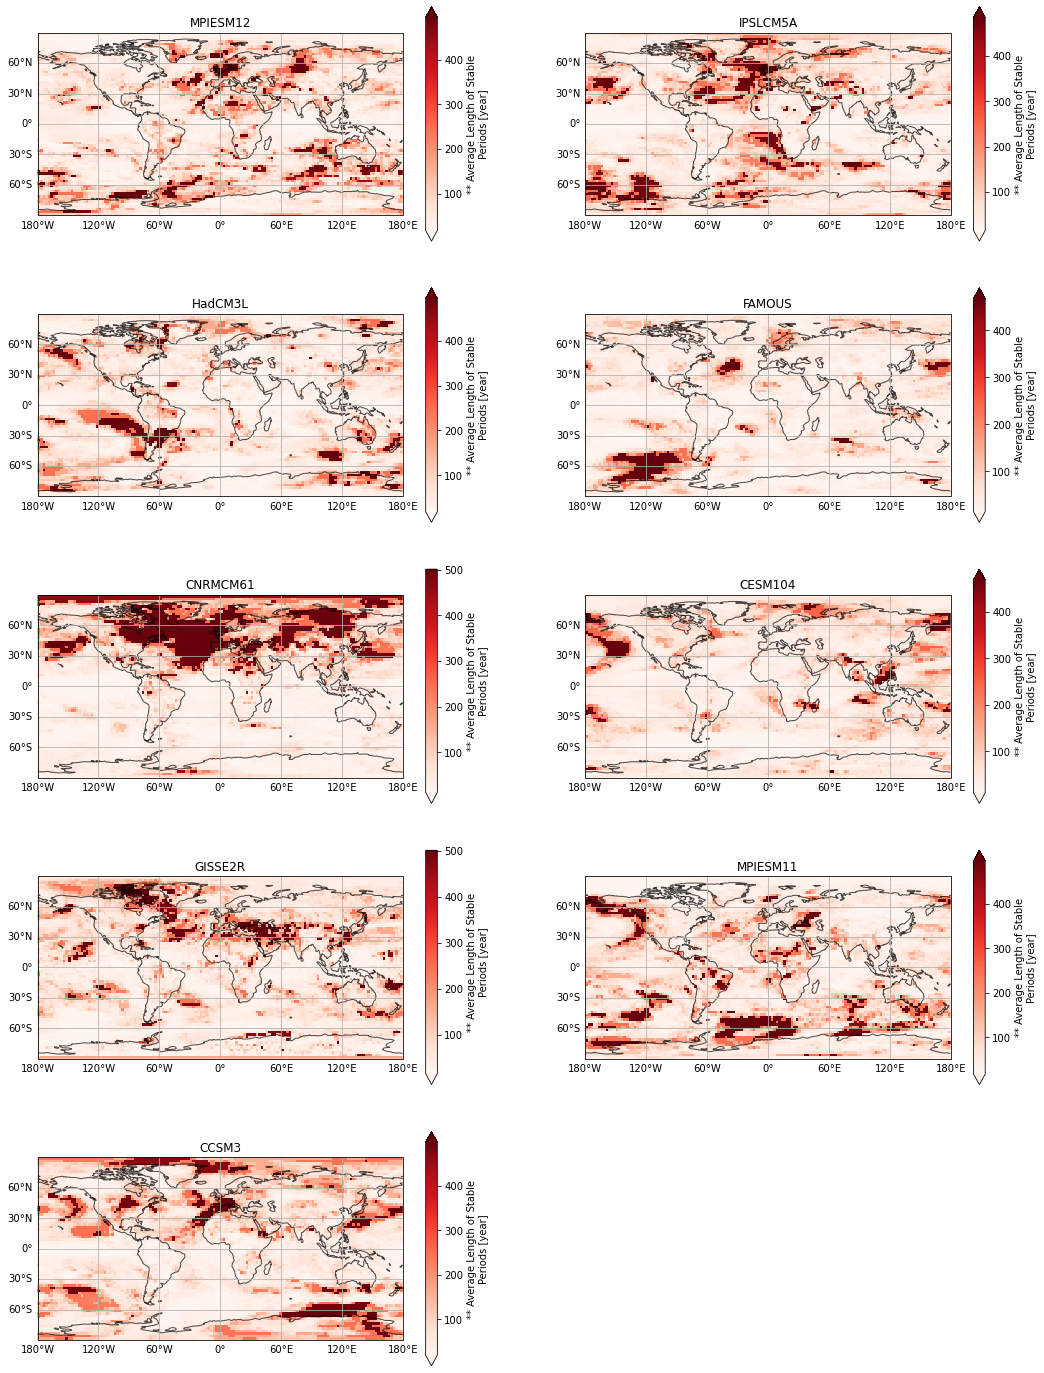

In [72]:
plot_all_model_maps(consec_ds, 'average_length')

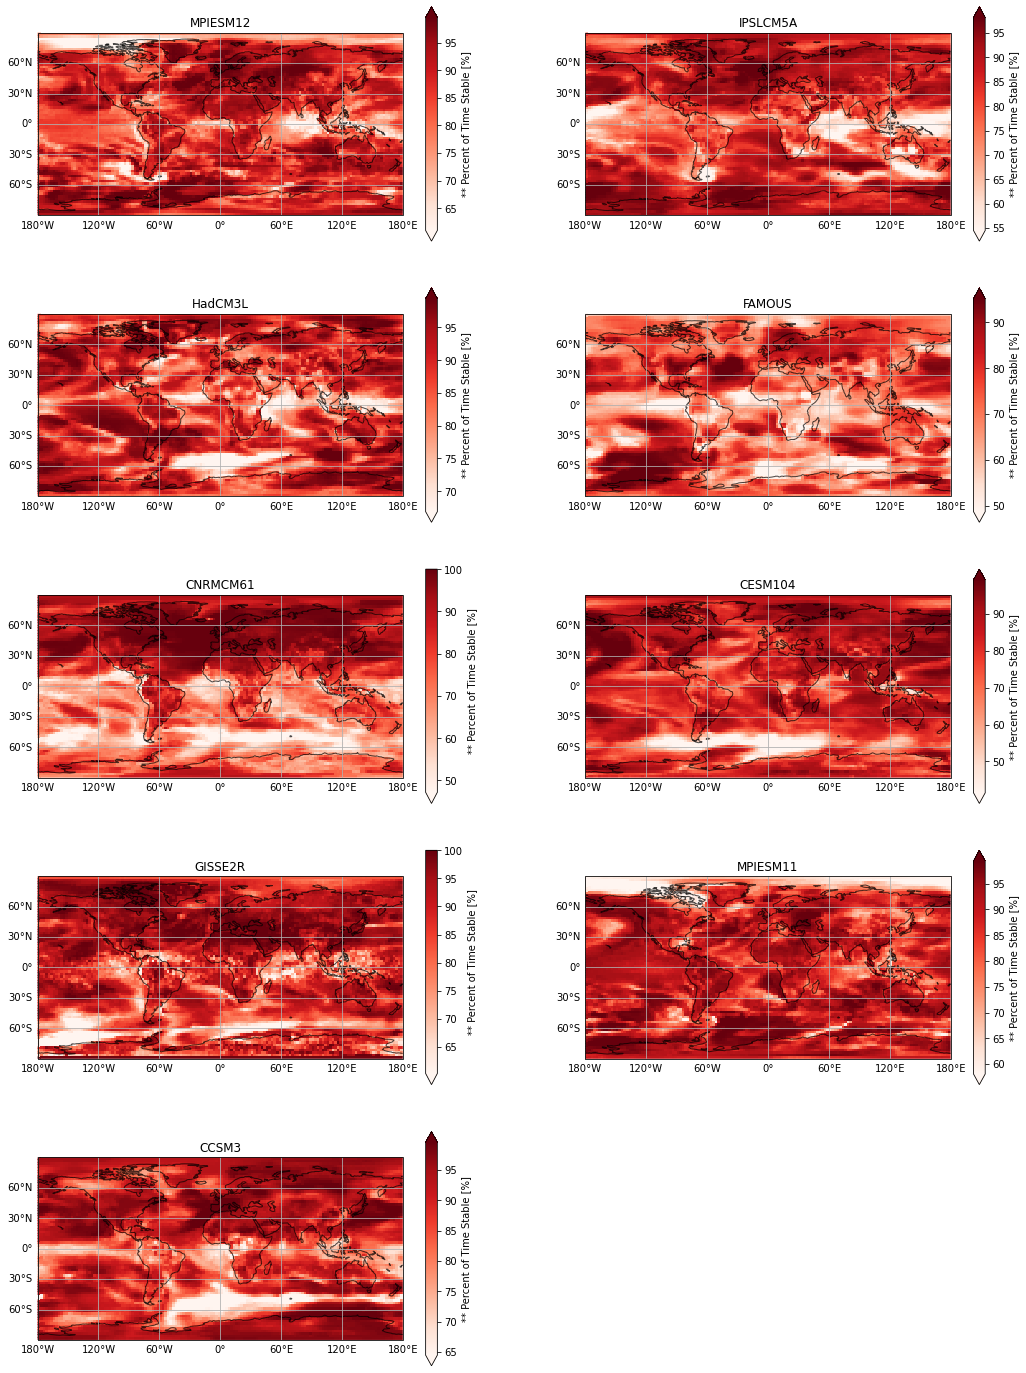

In [73]:
plot_all_model_maps(consec_ds, 'percent_time_stable')